## **Ubernet: Predicting short-term demand of hail-riding service**

The purpose of this blog is to describe the deep learning Convolutional Neural Network (CNN) for the short-term demand prediction of ride-hailing services, using spatio-temporal data of Uber pickups in new York City (DNN parameters of the convolutional layers and a WaveNet-like DCNN(Dilated Convoluted Neural Network) used for a time-series problem.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [2]:
train = pd.read_csv('/home/data.csv')


The objective is to forecast the next time step using past observations. Before fitting the model, it is necessary to partition the dataset into input and output windows. The objective is to forecast the output by utilising the inputs (previous observations) (future). The Uber raw data is derived from NYC Taxi & Limousine Commission (TLC) 2, which contains over 4.5365
million Uber pickups in New York City. The data is available as follows:

https://www1.nyc.gov/site/tlc/index.page

The data was given in terms of per second basis and we have performed a groupby operation, which leads to roughly 1.5 million datapoints. The last month data was used for test and the rest are for training. With respect to the data input, 4 basic date-based features are engineered. In addition, we also have created 4 lag(2) features. The target variable is also transformed in order to facilitate the prediction, so the RMSE needs to be rescaled when calculating the original pickups with varying intervals.

In [3]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model 
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('/home/data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13,14,15]], axis=1, inplace=True)
print(values)
print(reframed.head())

[[3.0000000e+00 3.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [5.0000000e+00 3.0000000e+00 0.0000000e+00 0.0000000e+00 2.7777778e-03]
 [6.0000000e+00 3.0000000e+00 0.0000000e+00 0.0000000e+00 5.5555557e-03]
 ...
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 2.3000000e+01 4.3439775e+03]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 2.3000000e+01 4.3439805e+03]
 [6.2000000e+01 1.0000000e+00 0.0000000e+00 2.3000000e+01 4.3439834e+03]]
   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)     var5(t-2)  var1(t-1)  \
2   0.014085        0.5        0.0        0.0  0.000000e+00   0.023474   
3   0.023474        0.5        0.0        0.0  6.394541e-07   0.028169   
4   0.028169        0.5        0.0        0.0  1.278908e-06   0.042254   
5   0.042254        0.5        0.0        0.0  1.918362e-06   0.018779   
6   0.018779        0.5        0.0        0.0  2.557816e-06   0.018779   

   var2(t-1)  var3(t-1)  var4(t-1)     var5(t-1)   var1(t)  var2(t)  var3(t)  \
2        0.5        0.0        

In [4]:

reframed = reframed[['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',  'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)','var1(t)']]

In [5]:
cols =reframed.columns.tolist()
print(cols)

['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var1(t)']


In [6]:
# split into train and test sets, the last month's data is used as test and the rest are train
values = reframed.values
n_train_hours = 365 * 24*60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_y)
print(test_X)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[0.02816901 0.04225352 0.01877934 ... 0.         0.26760563 0.        ]
[[0.26760563 0.         0.         ... 0.         0.86956525 0.33609834]
 [0.         0.         0.         ... 0.         0.86956525 0.33609897]
 [0.         0.         0.         ... 0.         0.86956525 0.3360996 ]
 ...
 [0.         0.16666667 0.         ... 0.         1.         0.9999986 ]
 [0.         0.16666667 0.         ... 0.         1.         0.9999993 ]
 [0.         0.16666667 0.         ... 0.         1.         1.        ]]
(525600, 1, 14) (525600,) (1038232, 1, 14) (1038232,)


Epoch 1/30
4107/4107 - 47s - loss: 0.0181 - val_loss: 0.0637 - 47s/epoch - 11ms/step
Epoch 2/30
4107/4107 - 22s - loss: 0.0157 - val_loss: 0.0648 - 22s/epoch - 5ms/step
Epoch 3/30
4107/4107 - 22s - loss: 0.0155 - val_loss: 0.0615 - 22s/epoch - 5ms/step
Epoch 4/30
4107/4107 - 32s - loss: 0.0153 - val_loss: 0.0557 - 32s/epoch - 8ms/step
Epoch 5/30
4107/4107 - 22s - loss: 0.0151 - val_loss: 0.0538 - 22s/epoch - 5ms/step
Epoch 6/30
4107/4107 - 23s - loss: 0.0147 - val_loss: 0.0538 - 23s/epoch - 6ms/step
Epoch 7/30
4107/4107 - 32s - loss: 0.0147 - val_loss: 0.0542 - 32s/epoch - 8ms/step
Epoch 8/30
4107/4107 - 31s - loss: 0.0146 - val_loss: 0.0543 - 31s/epoch - 8ms/step
Epoch 9/30
4107/4107 - 23s - loss: 0.0144 - val_loss: 0.0544 - 23s/epoch - 6ms/step
Epoch 10/30
4107/4107 - 22s - loss: 0.0142 - val_loss: 0.0552 - 22s/epoch - 5ms/step
Epoch 11/30
4107/4107 - 22s - loss: 0.0141 - val_loss: 0.0556 - 22s/epoch - 5ms/step
Epoch 12/30
4107/4107 - 22s - loss: 0.0141 - val_loss: 0.0562 - 22s/epoch

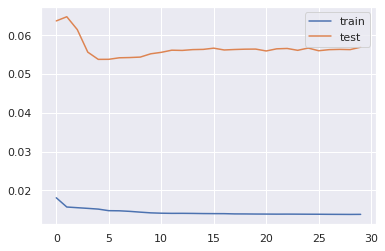

In [7]:
# The baseline model that uses LSTM


from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# design network
model = Sequential()
model.add(LSTM(5, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# print(train_X.shape[1], train_X.shape[2])
# model.add(Dense(5,activation ='relu'))
# model.add(LSTM(5, return_sequences=True))
# model.add(Dense(5,activation ='relu'))
# model.add(LSTM(5))
# model.add(Dense(5,activation ='relu'))
model.add(Dense(1, activation="tanh"))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0])
# invert scaling for forecast
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 0.13


Through the use of a separate cell controlled by input and forget gates, LSTMs enable long-term memory. This enables information to flow freely through a potentially infinite number of timesteps. Without these gates, information could easily vanish during each timestep's transformations.

Convolutional networks, on the other hand, do not exhibit the same type of vanishing gradient, and we demonstrate experimentally that they do not require forget gates. As a result, we consider models with only output gates, which enable the network to determine which information should be propagated through the layer hierarchy.

In [10]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'activation': self.activation,
        })
        return config 
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

## The Ubernet architecture

Epoch 1/20
7300/7300 - 49s - loss: 0.0212 - val_loss: 0.0455 - 49s/epoch - 7ms/step
Epoch 2/20
7300/7300 - 48s - loss: 0.0227 - val_loss: 0.0451 - 48s/epoch - 7ms/step
Epoch 3/20
7300/7300 - 45s - loss: 0.0227 - val_loss: 0.0450 - 45s/epoch - 6ms/step
Epoch 4/20
7300/7300 - 45s - loss: 0.0225 - val_loss: 0.0449 - 45s/epoch - 6ms/step
Epoch 5/20
7300/7300 - 66s - loss: 0.0228 - val_loss: 0.0451 - 66s/epoch - 9ms/step
Epoch 6/20
7300/7300 - 67s - loss: 0.0226 - val_loss: 0.0451 - 67s/epoch - 9ms/step
Epoch 7/20
7300/7300 - 73s - loss: 0.0228 - val_loss: 0.0451 - 73s/epoch - 10ms/step
Epoch 8/20
7300/7300 - 69s - loss: 0.0228 - val_loss: 0.0450 - 69s/epoch - 9ms/step
Epoch 9/20
7300/7300 - 50s - loss: 0.0228 - val_loss: 0.0451 - 50s/epoch - 7ms/step
Epoch 10/20
7300/7300 - 67s - loss: 0.0228 - val_loss: 0.0451 - 67s/epoch - 9ms/step
Epoch 11/20
7300/7300 - 66s - loss: 0.0228 - val_loss: 0.0451 - 66s/epoch - 9ms/step
Epoch 12/20
7300/7300 - 47s - loss: 0.0228 - val_loss: 0.0450 - 47s/epoch

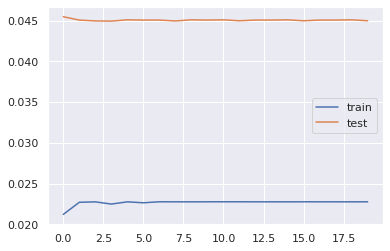

In [12]:
#p = "valid" 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model
from tensorflow.keras.optimizers import Adam
# from keras.layers.normalization import BatchNormalization
p='causal' # this only works in 1.12+ -- December 2018+

model2 = Sequential([
    #Conv1D(filters=n_filters, kernel_size=filter_width, padding='causal', dilation_rate=1),
    # padding= One of "valid" or "same"
    #Input(shape=(None, 1)), 
    #Input(shape=(None, num_x_signals)), This is not for Sequential
    Conv1D(filters=32, input_shape=( None, train_X.shape[2]), 
           kernel_size=1, padding='causal', dilation_rate=1),
    # BatchNormalization(),
    GatedActivationUnit(),
    Dropout(.5),
    Conv1D(filters=32, kernel_size=1, padding=p, dilation_rate=4),
    GatedActivationUnit(),
    # BatchNormalization(),
    Dropout(.5),
    Conv1D(filters=32, kernel_size=1, padding=p, dilation_rate=8),
    GatedActivationUnit(),
    Dense(50, activation="relu"), #model.add(Dense(num_y_signals, activation="tanh"))   #'sigmoid'))
    Dropout(.2),
    Dense(1, activation="tanh") 
    #Dense(1),
    
])


#optimizer = tf.train.RMSPropOptimizer(0.001)

model2.compile(Adam(), loss='mean_absolute_error')

# fit network
history = model2.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [13]:
yhat = model2.predict(test_X)
yhat = yhat.reshape(yhat.shape[0])
# invert scaling for forecast
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.126
